# Vectorize

In [1]:
import numpy as np
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import nltk
import string
import pandas as pd

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

%matplotlib inline
plt.style.use('fivethirtyeight')

# Loading FastText embedding

In [2]:
#This has a long download time...

import sister
embedder = sister.MeanEmbedding(lang="en")

Loading model...


# Word Cleaning Function


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
stemmer = WordNetLemmatizer()
stop_words_custom = ['company', "product", 'largest', "group", "alphabetically", "alphabeticallylist"]

def clean_text(text):
    '''
    Cleans a corpus of data by removing stop words, stemming words, and removing special characters
    '''
    
    assert isinstance(text, str)
    assert len(text) > 0
    
    #removing all alphanumeric 
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    
    #removing multiple spaces
    text = re.sub("\s\s+" , " ", text)

    
    #making everything lowercase 
    text = text.lower()
    
    #lemmatizing and remove 
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word not in stop_words_custom]
    words = [stemmer.lemmatize(word) for word in words]

    text = ' '.join(words)
    
    return text

    

[nltk_data] Downloading package stopwords to /home/dillon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dillon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#  Loading Data

In [4]:
data = pd.read_csv("scraped/updatedForbes Global 2000 - 2019.csv")
data

,Unnamed: 0,Company,Market Value,Revenue,Profits,Assets,Rank,Sector,Industry,Continent,Country,Headquarters,State,CEO,Forbes Webpage,Profits as % of Assets,Profits as % of Revenue,description
0,0,ICBC,305.057,175.874,45.223,4034.482,1,Financials,Major Banks,Asia,China,China,NaN,Shu Gu,http://www.forbes.com/companies/icbc/,0.011209,0.257133,Industrial and Commercial Bank of China Limite...
1,1,JPMorgan Chase,368.502,132.912,32.738,2737.188,2,Financials,Major Banks,North America,United States,New York,New York,Jamie Dimon,http://www.forbes.com/companies/jpmorgan-chase/,0.011960,0.246313,JPMorgan Chase & Co. is an American multinatio...
2,2,China Construction Bank,224.988,150.313,38.841,3382.422,3,Financials,Major Banks,Asia,China,China,NaN,Wang Zuji,http://www.forbes.com/companies/china-construc...,0.011483,0.258401,China Construction Bank Corporation (CCB) is o...
3,3,Agricultural Bank of China,197.045,137.456,30.894,3293.105,4,Financials,Regional Banks,Asia,China,China,NaN,Huan Zhao,http://www.forbes.com/companies/agricultural-b...,0.009381,0.224756,"Agricultural Bank of China (ABC), also known a..."
4,4,Bank of America,287.339,111.904,28.540,2377.164,5,Financials,Major Banks,North America,United States,North Carolina,North Carolina,Brian Moynihan,http://www.forbes.com/companies/bank-of-america/,0.012006,0.255040,The Bank of America Corporation (simply referr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Thai Oil,4.615,12.044,0.314,8.260,1996,Energy,Oil & Gas Operations,Asia,Thailand,Thailand,NaN,Atikom Terbsiri,http://www.forbes.com/companies/thai-oil/,0.038015,0.026071,Thai Oil Public Company Limited or simply Thai...
1996,1996,Bed Bath & Beyond,2.302,12.029,-0.137,6.619,1997,Consumer Discretionary,Specialty Stores,North America,United States,New Jersey,New Jersey,Steven H. Temares,http://www.forbes.com/companies/bed-bath-beyond/,-0.020698,-0.011389,Bed Bath & Beyond Inc. is an American chain of...
1997,1997,Incyte,15.847,1.882,0.109,2.646,1997,Health Care,Biotechs,North America,United States,Delaware,Delaware,Hervé Hoppenot,http://www.forbes.com/companies/incyte/,0.041194,0.057917,Incyte Corp is an American pharmaceutical comp...
1998,1998,Fuyo General Lease,1.530,5.574,0.209,23.179,1999,Financials,Rental & Leasing,Asia,Japan,Japan,NaN,Takashi Sato,http://www.forbes.com/companies/fuyo-general-l...,0.009017,0.037496,Meiji Yasuda Life Insurance Company (明治安田生命保険相...


# Vectorizing Text and Fitting PCA/Kmeans

Functions for vectorizing text and fitting Kmeans/PCA

In [5]:
def get_ft_vectors(data, embedder):
    '''
    gets fasttext embeddings for a pandas dataframe with column 'description' containing text
    '''
    
    assert isinstance(data, pd.DataFrame)
    assert isinstance(embedder, sister.MeanEmbedding)
    assert 'description' in  data.columns
    
    vectors = []
    for index, row in data.iterrows():
        text = row['description']
        if not isinstance(text, str):
            continue
        elif not text == "NEEDS_MANUAL_SUMMARY":
            vector = embedder(clean_text(text))
            vectors.append(vector)
    vectors = np.asarray(vectors)
    return vectors

vectors = get_ft_vectors(data, embedder)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectors(data):
    '''
    gets tfidf vectors for a pandas dataframe with column 'description' containing text
    '''

    cleaned_text = []
    assert isinstance(data, pd.DataFrame)
    assert 'description' in  data.columns

    for index, row in data.iterrows():
        text = row['description']
        if not isinstance(text, str):
            continue
        elif not text == "NEEDS_MANUAL_SUMMARY":
            cleaned_text.append(clean_text(text))
                
    tfidf_vectorizer = TfidfVectorizer(max_features = 2000)
    tfidf_vectors = tfidf_vectorizer.fit_transform(cleaned_text)
    return tfidf_vectors, tfidf_vectorizer

tfidf_vectors, tfidf_vectorizer = get_tfidf_vectors(data)

# Getting PCA transformers

In [7]:
pca_transformer = PCA(n_components = 3)

#since 
tfpca_transformer = TruncatedSVD(n_components=3)

proj_vectors = pca_transformer.fit_transform(vectors)
tfproj_vectors = tfpca_transformer.fit_transform(tfidf_vectors)

# Elbow Method for optimal clusters

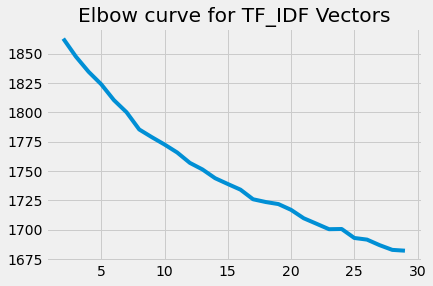

In [16]:
import scipy

def elbow_method(vectors, title):
    '''
    Makes plot for elbow method based on dataset vectors up to k=30
    '''

    #since array can be sparse or a normal dense array
    assert isinstance(vectors, scipy.sparse.csr.csr_matrix) or isinstance(vectors, np.ndarray)
    assert isinstance(title, str)
    
    inertia = []
    cluster_count = range(2, 30)

    for n in cluster_count:
        kmeans_elbow = KMeans(n_clusters = n, max_iter = 600)
        kmeans_elbow.fit(tfidf_vectors)
        inertia.append(kmeans_elbow.inertia_)

    fig = plt.figure()
    plt.plot(cluster_count, inertia)
    plt.grid(True)
    plt.title(title)
    
elbow_method(tfidf_vectors, 'Elbow curve for TF_IDF Vectors')

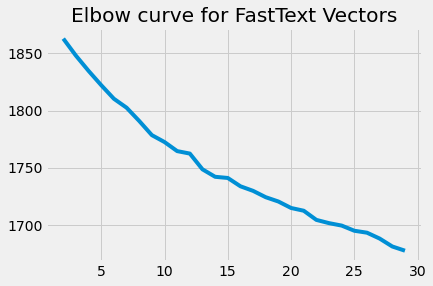

In [17]:
elbow_method(vectors, 'Elbow curve for FastText Vectors')

# Fitting KMeans

In [18]:
from sklearn.cluster import KMeans

kmeans_pca = KMeans(n_clusters=12, max_iter=600, algorithm = 'auto')
kmeans_pca.fit(proj_vectors)

KMeans(max_iter=600, n_clusters=12)

In [19]:
from sklearn.cluster import KMeans

kmeans_full = KMeans(n_clusters=12, max_iter=600, algorithm = 'auto')
kmeans_full.fit(vectors)


KMeans(max_iter=600, n_clusters=12)

In [20]:
from sklearn.cluster import KMeans

kmeans_tfidf = KMeans(n_clusters=17, max_iter=600, algorithm = 'auto')
kmeans_tfidf.fit(tfproj_vectors)


KMeans(max_iter=600, n_clusters=17)

# Finding Clusters and PCA Projections for companies

Function for adding features to the dataframe from the above functions and fitted models

In [22]:
def add_features(data, embedder, tfidf_vectorizer, pca_transformer, tfpca_transformer, kmeans_full, kmeans_tfidf):
    '''
    adds PCA and vector features to the dataframe
    
    '''

    assert isinstance(data, pd.DataFrame)
    assert isinstance(embedder, sister.MeanEmbedding)
    assert isinstance(tfidf_vectorizer, TfidfVectorizer)
    assert isinstance(pca_transformer, PCA)
    assert isinstance(tfpca_transformer, TruncatedSVD)
    assert isinstance(kmeans_full, KMeans)
    assert isinstance(kmeans_tfidf, KMeans)
    
    data = data.copy()
    
    for index, row in data.iterrows():
        text = row['description']
        if not isinstance(text, str):
            continue
        elif not text == "NEEDS_MANUAL_SUMMARY":
            vector = embedder(clean_text(text))
            tfidf_vector = tfidf_vectorizer.transform([clean_text(text)])

            vectorized = pca_transformer.transform(vector.reshape(1, -1))
            tf_vectorized = tfpca_transformer.transform(tfidf_vector.reshape(1, -1))

            data.loc[index, "full_cluster"] = kmeans_full.predict(vector.reshape(1, -1))
            data.loc[index, "pca_cluster"] = kmeans_pca.predict(vectorized)
            data.loc[index, "tfidf_cluster"] = kmeans_tfidf.predict(tf_vectorized)

            data.loc[index, "PCA_1"] = vectorized[:,0]
            data.loc[index, "PCA_2"] = vectorized[:,1]
            data.loc[index, "PCA_3"] = vectorized[:,2]

            data.loc[index, "PCAtfidf_1"] = tf_vectorized[:,0]
            data.loc[index, "PCAtfidf_2"] = tf_vectorized[:,1]
            data.loc[index, "PCAtfidf_3"] = tf_vectorized[:,2]

    return data

data = add_features(data, embedder, tfidf_vectorizer, pca_transformer, tfpca_transformer, kmeans_full, kmeans_tfidf)

# Plotting Clusters and Projections

We can now view how our clusters look when visualized with plotly

In [23]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)   


fig = px.scatter_3d(data, x="PCA_1", y="PCA_2", z="PCA_3", color="pca_cluster", hover_data=[
            "PCA_1", "PCA_2", 
            "PCA_3", "Company"])
fig.show()

In [24]:
import plotly.express as px

fig = px.scatter_3d(data, x="PCA_1", y="PCA_2", z="PCA_3", color="full_cluster", hover_data=[
            "PCA_1", "PCA_2", 
            "PCA_3", "Company"
        ])
fig.show()

In [25]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)   


fig = px.scatter_3d(data, x="PCAtfidf_1", y="PCAtfidf_2", z="PCAtfidf_3", color="tfidf_cluster", hover_data=[
            "PCA_1", "PCA_2", 
            "PCA_3", "Company"
        ])
fig.show()

# Test: Finding Category Names From Clusters

This is an experiment to see if we can find a name for the clusters based on the most prevalent words or Ngrams. It didn't work too well, but is interesting nonetheless


In [26]:
from collections import defaultdict, Counter
from nltk import ngrams
import math

cluster_corpus = defaultdict(list)


for index, row in data.iterrows():
    if not isinstance(row['description'], str):
        continue
    elif not row['description'] == "NEEDS_MANUAL_SUMMARY":
        if not math.isnan(row['tfidf_cluster']):
            cluster_corpus[row['tfidf_cluster']].extend(clean_text(row['description']))
        
cluster_n_gram = defaultdict(list)

 
for key in cluster_corpus.keys():
    counts = Counter()
    ngram_counts = Counter(ngrams("".join(cluster_corpus[key]).split(), 1))
    print(ngram_counts.most_common(2))
    


[(('bank',), 115), (('china',), 54)]
[(('bank',), 279), (('banking',), 132)]
[(('bank',), 81), (('hong',), 38)]
[(('bank',), 542), (('banking',), 85)]
[(('american',), 232), (('corporation',), 198)]
[(('china',), 191), (('chinese',), 81)]
[(('world',), 152), (('service',), 142)]
[(('bank',), 206), (('banking',), 61)]
[(('service',), 218), (('state',), 148)]
[(('world',), 129), (('corporation',), 123)]
[(('financial',), 151), (('bank',), 106)]
[(('world',), 122), (('corporation',), 106)]
[(('stock',), 146), (('exchange',), 128)]
[(('bank',), 259), (('banking',), 35)]
[(('steel',), 93), (('chinese',), 84)]
[(('china',), 108), (('index',), 85)]
[(('china',), 213), (('chinese',), 109)]


In [27]:
words = np.array(tfidf_vectorizer.get_feature_names())


for key in cluster_corpus.keys():
    
    cluster_vector = tfidf_vectorizer.transform(["".join(cluster_corpus[key])])
    tfidf_sorting = np.argsort(cluster_vector.toarray()).flatten()[::-1]
    top_n = words[tfidf_sorting][:3]
    print(top_n)

['bank' 'china' 'chinese']
['bank' 'banking' 'financial']
['bank' 'hong' 'kong']
['bank' 'india' 'banking']
['american' 'store' 'inc']
['china' 'chinese' 'kong']
['world' 'billion' 'service']
['bank' 'banking' 'rhb']
['service' 'energy' 'oil']
['world' 'corporation' 'market']
['financial' 'bank' 'asset']
['airline' 'hyundai' 'woolworth']
['stock' 'exchange' 'london']
['bank' 'branch' 'banking']
['steel' 'airport' 'chinese']
['china' 'index' 'stock']
['china' 'chinese' 'city']


# Putting it all together


We can now combine the worflow and functions from above to add the vectors, projections, and clusters to a big CSV for the dashboard to use

In [29]:
import pandas as pd
import os
from os.path import join
from tqdm.autonotebook import tqdm

i = 0

for file in tqdm(os.listdir(join(os.getcwd(), "scraped"))):
    print(file)
    if file.endswith(".csv"):
        
        #Getting year for current dataset
        data = pd.read_csv(join("scraped", file))
        year = file[-8:-4]
        print(year)
        
        #getting text vectors and projected vectors
        vectors = get_ft_vectors(data,embedder)
        tfidf_vectors, tfidf_vectorizer = get_tfidf_vectors(data)
    
        pca_transformer = PCA(n_components = 3)
        tfpca_transformer = TruncatedSVD(n_components=3)

        proj_vectors = pca_transformer.fit_transform(vectors)
        tfproj_vectors = tfpca_transformer.fit_transform(tfidf_vectors)
        
        #Fitting Kmeans 
        kmeans_pca = KMeans(n_clusters=12, max_iter=600, algorithm = 'auto')
        kmeans_pca.fit(proj_vectors)
        
        kmeans_full = KMeans(n_clusters=12, max_iter=600, algorithm = 'auto')
        kmeans_full.fit(vectors)
        
        kmeans_tfidf = KMeans(n_clusters=17, max_iter=600, algorithm = 'auto')
        kmeans_tfidf.fit(tfproj_vectors)
    
        #adding features to dataframe
        data = add_features(data, embedder, tfidf_vectorizer, pca_transformer, tfpca_transformer, kmeans_full, kmeans_tfidf)
        
        if i == 0:
            master_data = data
        else:
            master_data = pd.concat([master_data,data]).reset_index(drop = True)
        i += 1
       


updatedForbes Global 2000 - 2008.csv
2008
updatedForbes Global 2000 - 2009.csv
2009
updatedForbes Global 2000 - 2010.csv
2010
updatedForbes Global 2000 - 2011.csv
2011
updatedForbes Global 2000 - 2012.csv
2012
updatedForbes Global 2000 - 2013.csv
2013
updatedForbes Global 2000 - 2014.csv
2014
updatedForbes Global 2000 - 2015.csv
2015
updatedForbes Global 2000 - 2016.csv
2016
updatedForbes Global 2000 - 2017.csv
2017
updatedForbes Global 2000 - 2018.csv
2018
updatedForbes Global 2000 - 2019.csv
2019



In [30]:
master_data.to_pickle("Forbes Global 2000: 2008 - 2019.pkl")
master_data.to_csv("Forbes Global 2000: 2008 - 2019.csv")